In [1]:
# 繪圖設定字體顏色(否則黑色會看不到)
import matplotlib as mpl
COLOR1 = 'red'
COLOR2 = 'blue'
mpl.rcParams['text.color'] = COLOR1
mpl.rcParams['axes.labelcolor'] = COLOR2
mpl.rcParams['xtick.color'] = COLOR2
mpl.rcParams['ytick.color'] = COLOR2

# PY檔執行 + CV2顯示

In [ ]:
# convolutions.py 內容
from skimage.exposure import rescale_intensity
import numpy as np
import argparse
import cv2
# 原圖丟進來做convolution
def convolve(image, kernel):
    # 原圖 + kernel shape=(width, height)
    (iH, iW) = image.shape[:2]
    (kH, kW) = kernel.shape[:2]
    # 步長stride=1的情況下，如果要不改變output大小
    # output寬高 = ((input寬度m + 2為zero-padding - k為窗口寬度) / stride) + 1
        # iW = ((iW + 2*pad - kW) / 1) + 1
        # 如果不padding，output縮減幅度為kernal-1(理解為做到最後一次kernal的大小變成1)
    pad = int((kW - 1) / 2)
    # 填上邊界
        # cv2.copyMakeBorder(src原圖, top, bottom, left, right, borderType, value)
            # top, bottom, left, right為上下左右的邊界長度
            # borderType為填充邊界方法(見OpenCV教學：14.xxxx/02.OpenCV-1)
                # cv2.BORDER_REPLICATE：複製法，複製最邊緣像素
                # cv2.BORDER_REFLECT：反射法，以最邊緣像素 進行對稱(最邊界像素重複)
                # cv2.BORDER_REFLECT_101：對稱法，以最邊緣像素 進行對稱(最邊界像素不重複)
                # cv2.BORDER_WRAP：外包裝，一組像素重複
                # cv2.BORDER_CONSTANT：常量法，固定填某個指定值
            # value為填充方法是cv2.BORDER_CONSTANT時，填入的顏色
    image = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REPLICATE)
    # output初始化
    output = np.zeros((iH, iW), dtype="float32")
    # padding之後的座標 (x, y)為convolution的中心點，寬高都要加上pad
    for y in np.arange(pad, iH + pad):
        for x in np.arange(pad, iW + pad):
            # 座標(x, y)為中心點的卷積運算區域 = 上下左右各擴展pad = 2*pad+1的寬高
            roi = image[y-pad:y+pad+1, x-pad:x+pad+1]
            # 直接element-wise卷積運算(相乘之後加總) → 存到中心點
            k = (roi * kernel).sum()
            # 放到output相對座標，扣掉原本加上去的pad
            output[y - pad, x - pad] = k
    # skimage.exposure.rescale_intensity(圖片, in_range='image', out_range='dtype')
        # in_range 表示輸入圖片的強度範圍，預設為'image', 表示用影象的最大/最小畫素值作為範圍
        # out_range 表示輸出圖片的強度範圍，預設為'dype', 表示用影象的型別的最大/最小值作為範圍
        # 預設輸入圖片的[min, max]範圍被拉伸到[dtype.min, dtype.max]
            # 如果dtype=uint8, 那麼dtype.min=0, dtype.max=255
        # output的dtype為float，範圍 [0, 1]
    output = rescale_intensity(output, in_range=(0, 255))
    # 數值轉[0, 255]的uint8
    output = (output * 255).astype("uint8")
    return output

# 參數解析：args["image"]得到cmd輸入的參數-即圖檔名稱
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True, help="path to the input image")
args = vars(ap.parse_args())

# 各種Kernal
# construct average blurring kernels used to smooth an image 去躁模糊化
smallBlur = np.ones((7, 7), dtype="float") * (1.0 / (7 * 7))
largeBlur = np.ones((21, 21), dtype="float") * (1.0 / (21 * 21))
# construct a sharpening filter 銳化矩陣
sharpen = np.array(([0, -1, 0], 
                    [-1, 5, -1], 
                    [0, -1, 0]), dtype="int")
# construct the Laplacian kernel used to detect edge-like regions of an image 抓取邊緣矩陣
laplacian = np.array(([0, 1, 0], 
                      [1, -4, 1], 
                      [0, 1, 0]), dtype="int")
# construct the Sobel x-axis kernel X軸取邊緣矩陣(中間colomn擺0)
sobelX = np.array(([-1, 0, 1], 
                   [-2, 0, 2], 
                   [-1, 0, 1]), dtype="int")
# construct the Sobel y-axis kernel Y軸取邊緣矩陣(中間row擺0)
sobelY = np.array(([-1, -2, -1], 
                   [0, 0, 0], 
                   [1, 2, 1]), dtype="int")
# kernel bank
kernelBank = (("small_blur", smallBlur), ("large_blur", largeBlur), ("sharpen", sharpen), 
              ("laplacian", laplacian), ("sobel_x", sobelX), ("sobel_y", sobelY))

# 讀取圖檔轉灰階顯示：圖檔路徑 要和執行檔同一階層
image = cv2.imread(args["image"])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# 顯示原圖
cv2.imshow("original", gray)

# 各種kernal進行卷積運算
for (kernelName, kernel) in kernelBank:
    print("[INFO] applying {} kernel".format(kernelName))
    # 呼叫上方convolve(image, kernel) 進行卷積運算
    convoleOutput = convolve(gray, kernel)
    # 也可以內建函數進行卷積運算
    opencvOutput = cv2.filter2D(gray, -1, kernel)
    # show the output images
    cv2.imshow("{} - convole".format(kernelName), convoleOutput)
    #cv2.imshow("{} - opencv".format(kernelName), opencvOutput)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [2]:
%run convolutions.py --image baby.jpg

[INFO] applying small_blur kernel
[INFO] applying large_blur kernel
[INFO] applying sharpen kernel
[INFO] applying laplacian kernel
[INFO] applying sobel_x kernel
[INFO] applying sobel_y kernel


# Jupyter + Matplotlib顯示

In [11]:
from skimage.exposure import rescale_intensity
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
# 原圖丟進來做convolution
def convolve(image, kernel):
    # 原圖 + kernel shape=(width, height)
    (iH, iW) = image.shape[:2]
    (kH, kW) = kernel.shape[:2]
    # pad
    pad = int((kW - 1) / 2)
    # 填上邊界
    image = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REPLICATE)
    # output初始化
    output = np.zeros((iH, iW), dtype="float32")
    # padding之後的座標 (x, y)為convolution的中心點，寬高都要加上pad
    for y in np.arange(pad, iH + pad):
        for x in np.arange(pad, iW + pad):
            # 座標(x, y)為中心點的卷積運算區域 = 上下左右各擴展pad = 2*pad+1的寬高
            roi = image[y-pad:y+pad+1, x-pad:x+pad+1]
            # 直接element-wise卷積運算(相乘之後加總) → 存到中心點
            k = (roi * kernel).sum()
            # 放到output相對座標，扣掉原本加上去的pad
            output[y - pad, x - pad] = k
    output = rescale_intensity(output, in_range=(0, 255))
    output = (output * 255).astype("uint8")
    return output

# 各種Kernal
# construct average blurring kernels used to smooth an image 去躁模糊化
smallBlur = np.ones((7, 7), dtype="float") * (1.0 / (7 * 7))
largeBlur = np.ones((21, 21), dtype="float") * (1.0 / (21 * 21))
# construct a sharpening filter 銳化矩陣
sharpen = np.array(([0, -1, 0], 
                    [-1, 5, -1], 
                    [0, -1, 0]), dtype="int")
# construct the Laplacian kernel used to detect edge-like regions of an image 抓取邊緣矩陣
laplacian = np.array(([0, 1, 0], 
                      [1, -4, 1], 
                      [0, 1, 0]), dtype="int")
# construct the Sobel x-axis kernel X軸取邊緣矩陣(中間colomn擺0)
sobelX = np.array(([-1, 0, 1], 
                   [-2, 0, 2], 
                   [-1, 0, 1]), dtype="int")
# construct the Sobel y-axis kernel Y軸取邊緣矩陣(中間row擺0)
sobelY = np.array(([-1, -2, -1], 
                   [0, 0, 0], 
                   [1, 2, 1]), dtype="int")
# kernel bank
kernelBank = (("small_blur", smallBlur), ("large_blur", largeBlur), ("sharpen", sharpen), 
              ("laplacian", laplacian), ("sobel_x", sobelX), ("sobel_y", sobelY))

# 讀取圖檔轉灰階顯示：圖檔路徑 要和執行檔同一階層
image = cv2.imread('baby.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 各種kernal進行卷積運算
X = []    # 圖檔矩陣
y = []    # kernal名稱
for (kernelName, kernel) in kernelBank:
    print("[INFO] applying {} kernel".format(kernelName))
    # 呼叫上方convolve(image, kernel) 進行卷積運算
    convoleOutput = convolve(gray, kernel)
    convoleOutput_RGB = cv2.cvtColor(convoleOutput, cv2.COLOR_BGR2RGB)
    X.append(convoleOutput_RGB)
    y.append(kernelName)

[INFO] applying small_blur kernel
[INFO] applying large_blur kernel
[INFO] applying sharpen kernel
[INFO] applying laplacian kernel
[INFO] applying sobel_x kernel
[INFO] applying sobel_y kernel


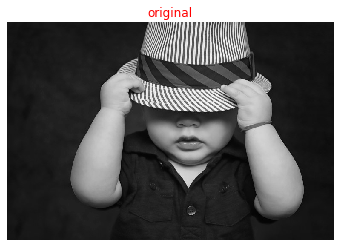

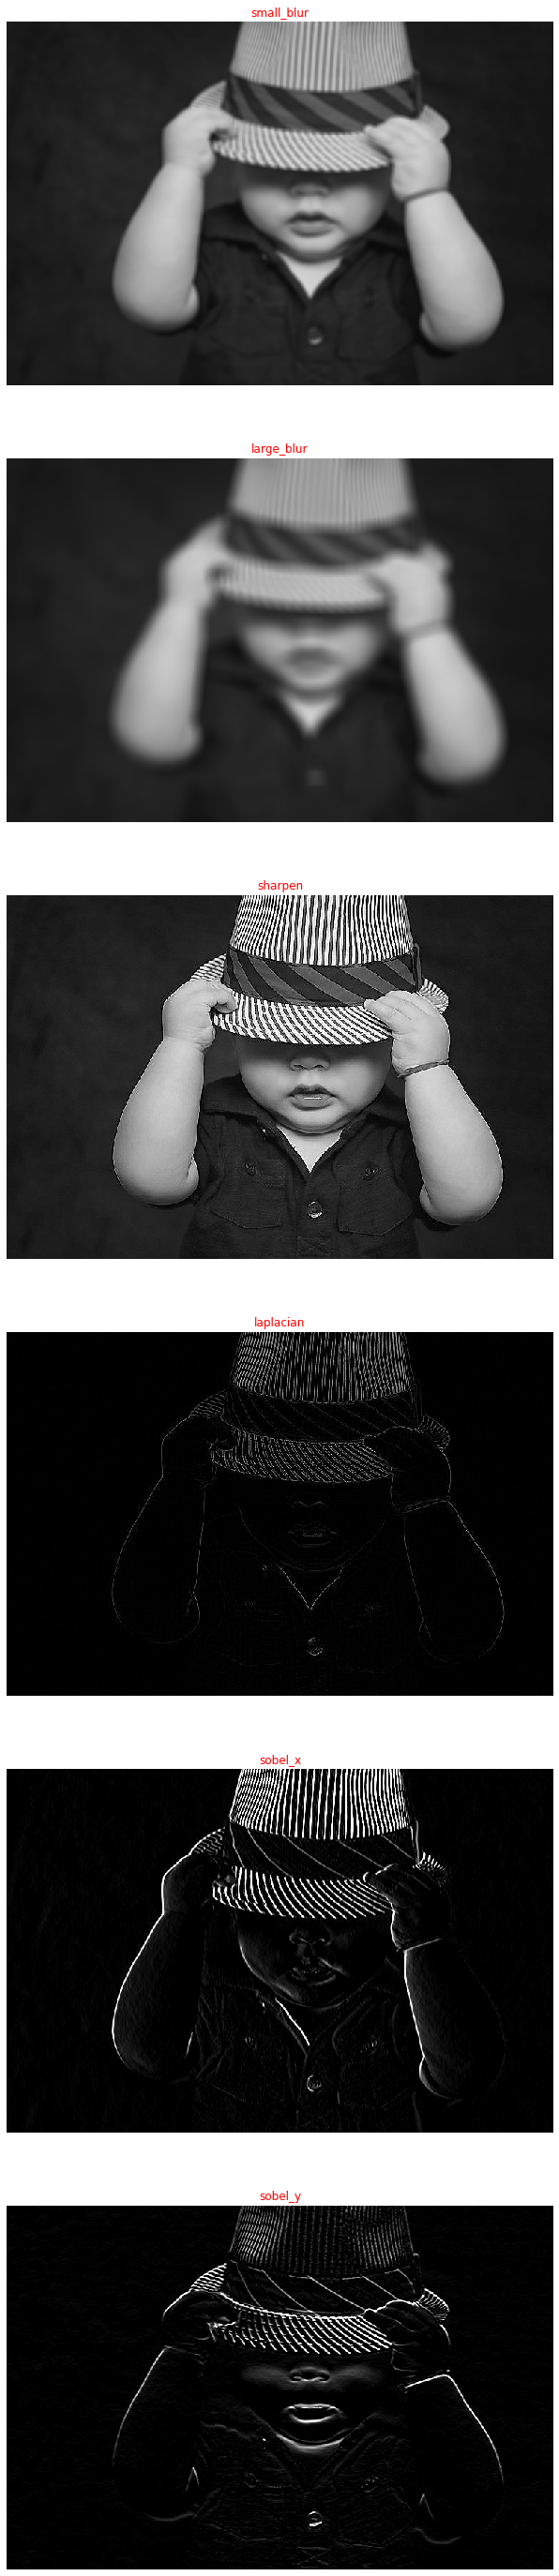

In [12]:
# 原圖
plt.title('original')
plt.axis('off')
plt.imshow(gray, cmap='gray')
# show the output images
plt.figure(figsize=(50, 50))
count = len(X)
for i in range(count):
    plt.subplot(count, 1, i+1)
    plt.title(y[i])
    plt.axis('off')
    plt.imshow(X[i])